In [182]:
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
from nerf2d import NeRF2D_LightningModule

nerf = NeRF2D_LightningModule.load_from_checkpoint(
    'checkpoints/last.ckpt'
).cpu()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
from torch.utils.data import DataLoader
from pathlib import Path
from nerf2d_dataset import read_image_folder, NeRFDataset2D

test_folder = '/home/jorge/repos/NeRF2D/data/cube/test'
ims, poses, focal, depths = read_image_folder(Path(test_folder))
dataset = NeRFDataset2D(ims, poses, focal, depths)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

def show_color(color):
    fig, ax = plt.subplots(1, figsize=(1, 1))
    ax.imshow(color.expand(1, 1, 3).detach().numpy())
    ax.set_axis_off()
    plt.show()

def get_nth_batch(n, loader):
    for i, batch in enumerate(loader):
        if i == n:
            return batch

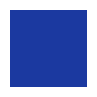

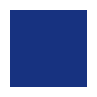

tensor(0.0059, grad_fn=<MseLossBackward0>)

In [151]:
# get batch and evaluate it
o, d, color, depth = get_nth_batch(20, dataloader)
color_pred, weights, ts = nerf(o, d)

show_color(color_pred[0])
show_color(color[0])

color_loss = nerf.color_loss(color_pred, color)
color_loss

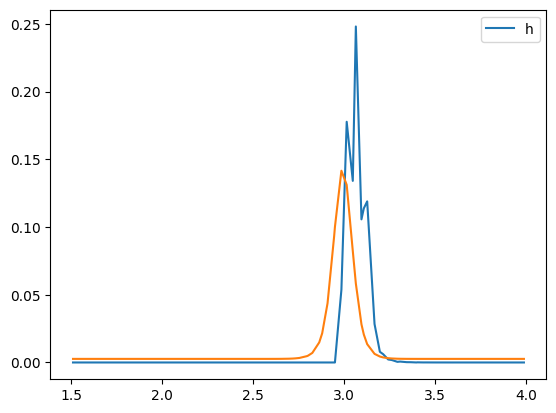

In [244]:


def gaussian_pdf(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))

def plot_depth_distributions(weights, ts, depth_gt, depth_std):
    gaussian = gaussian_pdf(ts, depth_gt, depth_std)

    plt.plot(ts, weights.detach(), label='h')
    plt.legend()

plot_depth_distributions(weights[0].detach(), ts, depth[0], 0.1)
import torch.nn.functional as F

depth_gt = F.softmax(gaussian_pdf(ts, depth, 0.1), dim=1)
plt.plot(ts, depth_gt[0])
plt.show()

depth_gt = gaussian_pdf(ts, depth, 0.1)
# F.kl_div(F.log_softmax(weights, dim=1), F.softmax(depth_gt, dim=0))

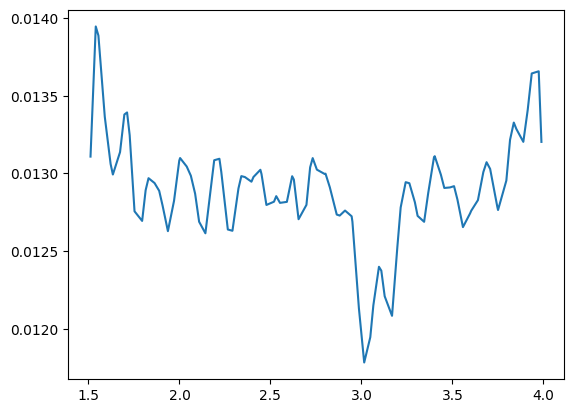

In [262]:


import torch

def depth_loss(ts, weights, d_gt, d_sigma=0.02):
    """
    :param ts: T
    :param weights: N,T
    :param d_gt: N,1
    :param d_sigma: float
    :return: 
    """

    depth_gt = gaussian_pdf(ts, d_gt, 0.1)
    return F.kl_div(F.log_softmax(weights, dim=1), F.softmax(depth_gt, dim=1))

    # dists = ts[1:] - ts[:-1]
    # dists = torch.cat([dists, torch.Tensor([1e10])])
    # dists = torch.cat([dists, torch.Tensor([0])])

    # loss = -torch.log(weights + 1e-5) * torch.exp(-(ts - d_gt) ** 2 / (2 * d_sigma)) * dists
    # loss = loss.sum()

    # return F.kl_div(F.log_softmax(weights, dim=1), F.one_hot())

losses = []
for d in ts:
    losses.append(depth_loss(ts, weights, torch.Tensor([[d]]), 0.1).item())

plt.plot(ts, losses)